In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import numpy as np #For Linear Algebra
import pandas as pd #For Data Frame Making
import matplotlib.pyplot as plt #For Visualization And Plot Making
from sklearn.model_selection import train_test_split #For Data Spliting 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The Available Device Is {device}")

The Available Device Is cpu


In [4]:
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.00001

In [5]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [6]:
X = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype("float32")/255.0
y = train_data.iloc[:, 0].values

X_test_final = test_data.values.reshape(-1, 1, 28, 28).astype("float32")/255.0

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

In [8]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [9]:
#Make Our Dataloader(The Input Of Our Model)

#Pytorch Train And Test Sets

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

#Dataloader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

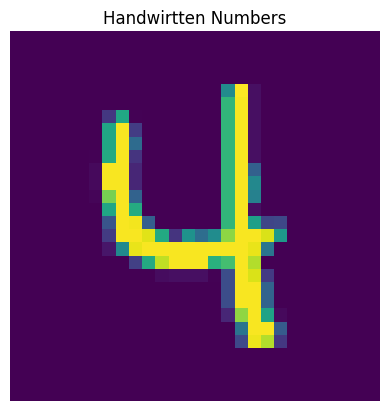

torch.Size([1, 28, 28])


In [10]:
plt.imshow(X_train[1].reshape(28, 28, 1))
plt.axis("off")
plt.title("Handwirtten Numbers")
plt.show()
print(X_train[1].shape)

In [11]:
#Let's Build Our Classifier Model

class CNN(nn.Module):    
    def __init__(self):
        super(CNN, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [12]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
#The Train Function

def train(epoch):
    model.train()
    optimizer.step()
    for batch_idx, (data, target) in enumerate(train_loader):        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [14]:
#The Evaluate Step

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        output = model(data)
        
        loss += criterion(output, target)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [15]:
for epoch in range(EPOCHS):
    train(epoch)
    evaluate(test_loader)

Train Epoch: 0 [6400/37800 (17%)]	Loss: 2.200952
Train Epoch: 0 [12800/37800 (34%)]	Loss: 1.937918
Train Epoch: 0 [19200/37800 (51%)]	Loss: 1.772126
Train Epoch: 0 [25600/37800 (68%)]	Loss: 1.649909
Train Epoch: 0 [32000/37800 (85%)]	Loss: 1.372583

Average loss: 0.0182, Accuracy: 3407/4200 (81.119%)

Train Epoch: 1 [6400/37800 (17%)]	Loss: 1.173935
Train Epoch: 1 [12800/37800 (34%)]	Loss: 0.981009
Train Epoch: 1 [19200/37800 (51%)]	Loss: 1.047101
Train Epoch: 1 [25600/37800 (68%)]	Loss: 0.846099
Train Epoch: 1 [32000/37800 (85%)]	Loss: 0.837150

Average loss: 0.0100, Accuracy: 3740/4200 (89.048%)

Train Epoch: 2 [6400/37800 (17%)]	Loss: 0.861128
Train Epoch: 2 [12800/37800 (34%)]	Loss: 0.738103
Train Epoch: 2 [19200/37800 (51%)]	Loss: 0.673383
Train Epoch: 2 [25600/37800 (68%)]	Loss: 0.593615
Train Epoch: 2 [32000/37800 (85%)]	Loss: 0.628873

Average loss: 0.0063, Accuracy: 3880/4200 (92.381%)

Train Epoch: 3 [6400/37800 (17%)]	Loss: 0.471195
Train Epoch: 3 [12800/37800 (34%)]	Loss: 0

In [16]:
#Make Our Predictions On Test Data

test_tn = torch.from_numpy(X_test_final)
fake_labels = np.zeros(X_test_final.shape)
fake_labels = torch.from_numpy(fake_labels)

#Test And Train Set

submission_tn_data = torch.utils.data.TensorDataset(test_tn, fake_labels)

#Make Dataloader

submission_loader = torch.utils.data.DataLoader(submission_tn_data, batch_size = BATCH_SIZE, shuffle = False)

In [17]:
#Let's Make Prediction

predictions = []

with torch.no_grad():
    model.eval()
    for images, _ in submission_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

In [18]:
# Create the submission DataFrame

submission_df = pd.DataFrame({
    "ImageId": np.arange(1, len(predictions) + 1),
    "Label": predictions
})

In [19]:
# Save the submission DataFrame to CSV

submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
